# Imports

In [1]:
import jupyter_black

import sys, os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.utils import make_grid, save_image

import lightning.pytorch as pl

jupyter_black.load()


if "/usr/src" not in sys.path:
    sys.path.append("/usr/src")

In [2]:
# Import custom modules

import helper_plots as hplt
from helper_train import count_fid_metric
import dataset

from models.vae_lightning import Encoder, Decoder, VariationalAutoEncoder

## Settings

In [3]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Hyperparameters
RANDOM_SEED = 111
LEARNING_RATE = 0.0005
NUM_EPOCHS = 200
BATCH_SIZE = 128
IMAGE_SIZE = 64
CHANNELS = 1
LATENT_SIZE = 4
RECONSTRUCTION_TERM_WEIGHT = 1

## Dataset

In [4]:
# Directory with source data

cells_dir = "/usr/src/data/separated_bacterias"
samples_dir = "/usr/src/samples"

transform = transforms.Compose(
    [
        transforms.ToPILImage(),
        dataset.CellPadResize(IMAGE_SIZE),
        transforms.ToTensor(),
    ]
)

dataset = dataset.ImageDataset(cells_dir, "cell", transform=transform)
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [5]:
# Check dataset and trainloader

print(f"Len of dataset:  {len(dataset)} images")
print(f"Len of trainloader:  {len(train_loader)} batches")
print(f"Shape of batch:  {next(iter(train_loader)).shape}")

Len of dataset:  1910 images
Len of trainloader:  15 batches
Shape of batch:  torch.Size([128, 1, 64, 64])


In [8]:
encoder = Encoder(IMAGE_SIZE, LATENT_SIZE, DEVICE)
decoder = Decoder(IMAGE_SIZE, LATENT_SIZE)

# lr = 0.001 by default
vae = VariationalAutoEncoder(encoder, decoder).to(DEVICE)

In [ ]:
trainer = pl.Trainer(max_epochs=NUM_EPOCHS, log_every_n_steps=5)
trainer.fit(vae, train_dataloaders=train_loader)

In [12]:
# Save trained model

torch.save(vae, f"vae_latent_{LATENT_SIZE}_{NUM_EPOCHS}_epochs.pt")

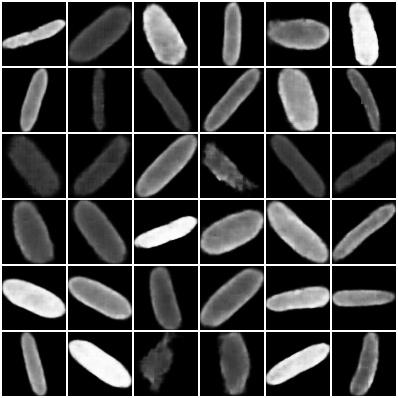

In [10]:
# Create grid of generated samples and show it

samples = hplt.show_grid_samples(vae, 36, "grid_cells_vae")

In [ ]:
hplt.generate_and_save_samples(samples_dir, 20, 20, vae, IMAGE_SIZE)

In [11]:
count_fid_metric(train_loader, vae, IMAGE_SIZE, LATENT_SIZE, CHANNELS)

1024 samples are generated, time = 0.914 sec
FID is computed, time = 79.581 sec


tensor(75.8458)